## 引言
GBDT（Gradient Boosting Decision Tree）是一种迭代的决策树算法，又叫 MART（Multiple Additive Regression Tree)，它通过构造一组弱的学习器（树），并把多颗决策树的结果累加起来作为最终的预测输出。该算法将决策树与集成思想进行了有效的结合。

GBDT的思想使其具有天然优势可以发现多种有区分性的特征以及特征组合。自算法的诞生之初，它就和SVM一起被认为是泛化能力（generalization）较强的算法。近些年来更因为被用于构建搜索排序的机器学习模型而引起广泛的关注。它最早见于yahoo，后被广泛应用在搜索排序、点击率预估上。业界中，Facebook使用其来自动发现有效的特征、特征组合，来作为LR模型中的特征，以提高 CTR预估（Click-Through Rate Prediction）的准确性；GBDT在淘宝的搜索及预测业务上也发挥了重要作用。

除此之外，GBDT还是目前竞赛中最为常用的一种机器学习算法，因为它不仅可以适用于多种场景，而且相比较于其他算法还有着出众的准确率，如此优异的性能也让GBDT收获了机器学习领域的“屠龙刀”这一赞誉。

本文首先介绍GBDT中的DT，即回归树，这是它的基础算法；然后叙述提升树，它是以决策树为基函数的提升方法；接着介绍GBDT中的GB，即梯度提升；最后导出GBDT算法的整个流程。

————————————————
版权声明：本文为CSDN博主「anshuai_aw1」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/anshuai_aw1/article/details/82888222

## Regression Desicion Tree：回归树
### 2.1 回归树简介
决策树模型分为分类树和回归树，分类树常用来分类问题，回归树常用来预测问题。分类树常用于分类标签值，比如用户性别、网页是否是垃圾页面、用户是不是作弊；而回归树常用于预测真实数值，比如用户的年龄、用户点击的概率、网页相关程度等等。

回归树总体流程类似于分类树，区别在于，回归树的每一个节点都会得到一个预测值，以年龄为例，该预测值等于属于这个节点的所有人年龄的平均值。分枝时穷举每一个feature的每个阈值寻找最优切分变量和最优切分点，但衡量的准则不再是分类树中的基尼系数，而是平方误差最小化。也就是被预测错误的人数越多，平方误差就越大，通过最小化平方误差找到最可靠的分枝依据。分枝直到每个叶子节点上人的年龄都唯一或者达到预设的终止条件(如叶子个数上限)，若最终叶子节点上人的年龄不唯一，则以该节点上所有人的平均年龄做为该叶子节点的预测年龄。

由于GBDT的核心在于累加所有树的结果作为最终结果，而分类树得到的离散分类结果对于预测分类并不是这么的容易叠加（稍等后面会看到，其实并不是简单的叠加，而是每一步每一棵树拟合的残差和选择分裂点评价方式都是经过公式推导得到的），而对基于回归树所得到的数值进行加减是有意义的（例如10岁+5岁-3岁=12岁），这是区别于分类树的一个显著特征（毕竟男+女=是男是女?，这样的运算是毫无道理的），GBDT在运行时就使用到了回归树的这个性质，它将累加所有树的结果作为最终结果。所以GBDT中的树都是回归树，而不是分类树，它用来做回归预测，当然回归树经过调整之后也能用来做分类。（如何做分类，稍后会介绍，这是一个需要注意的地方）

### 2.2 回归树的生成
首先看一个简单的回归树生成实例：
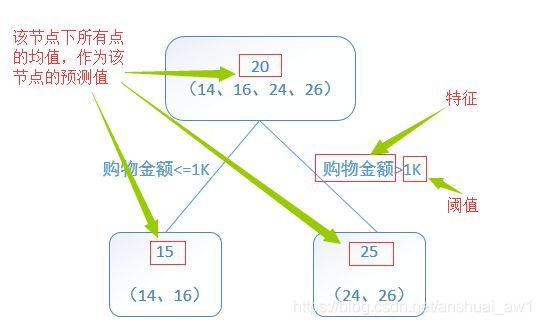

接下来具体说说回归树是如何进行特征选择生成二叉回归树的。
假设$X$与$Y$分别为输入和输出变量，并且$Y$是连续变量，给定训练数据集
$$
D=\left\{\left(x_{1}, y_{1}\right),\left(x_{2}, y_{2}\right), \cdots,\left(x_{N}, y_{N}\right)\right\}
$$

我们利用最小二乘回归树生成算法来生成回归树$f(x)$，即在训练数据集所在的输入空间中，递归地将每个区域分为两个子区域并决定每个子区域上的输出值，构建二叉决策树，步骤如下：
1）选择最优切分变量$j$与切分点$s$，求解

$$
\min _{j, s}\left[\min _{c_{1}} \sum_{x_{i} \in R_{1}(j, s)}\left(y_{i}-c_{1}\right)^{2}+\min _{c_{2}} \sum_{x_{i} \in R_{2}(j, s)}\left(y_{i}-c_{2}\right)^{2}\right]
$$

遍历变量$j$，对固定的切分变量$j$扫描切分点$s$，选择使上式达到最小值得对$j$, $s$
2）用选定的对$(j,s)$划分区域并决定相应的输出值：

$$
R_{1}(j, s)=\left\{x \mid x^{(j)} \leq s\right\}, R_{2}(j, s)=\left\{x \mid x^{(j)}>s\right\}
$$

3）继续对两个子区域调用步骤（1），（2），直至满足停止条件。

4）将输入空间划分为$M$个区域$R_1,R_2,\ldots,R_M$,在每个单元$R_m$上有一个固定的输出值$c_m$,生成决策树：

$$
f(x)=\sum_{m=1}^{M} \hat{c}_{m} \mathrm{I}\left(\mathrm{x} \in \mathrm{R}_{\mathrm{m}}\right)
$$

## 三、Boosting Decision Tree：提升树
### 3.1 提升树模型
提升方法采用加法模型（即基函数的线性组合）与前向分布算法。以决策树为基函数的提升方法称为提升树（Boosting tree）。对分类问题构建的决策树是二叉分类树，对回归问题构建决策树是二叉回归树。提升树是迭代多棵回归树来共同决策。当采用平方误差损失函数时，每一棵回归树学习的是之前所有树的结论和残差，拟合得到一个当前的残差回归树，残差的意义如公式：残差 = 真实值 - 预测值 。提升树即是整个迭代过程生成的回归树的累加。提升树模型可以表示为决策树的加法模型

$$
f_{M}(x)=\sum_{m=1}^{M} T\left(x ; \Theta_{m}\right)
$$
其中$T\left(x ; \Theta_{m}\right)$表示决策树；$\Theta_{m}$为决策树的参数；$M$为树的个数

### 3.2 提升树算法
对回归问题的提升树算法来说，给定当前模型$f_{m-1}(x)$只需要简单地拟合当前模型的残差。现将回归问题的提升树算法叙述如下:
1) 初始化$f_0(x)=0$
2) 对$m = 1,2,\ldots,M$

    - a)计算残差
$$
r_{m i}=y_{i}-f_{m-1}\left(x_{i}\right), i=1,2, \cdots, N
$$   
    - b)拟合残差$\gamma$学习一个回归树,得到$T\left(x ; \Theta_{m}\right)$
    - c)更新$f_{m-1}\left(x\right)+T\left(x ; \Theta_{m}\right)$
    
3) 得到回归问题提升树
    
$$
f_{M}(x)=\sum_{m=1}^{M} T\left(x ; \Theta_{m}\right)
$$

接下来通过训练一个用于预测年龄的模型来展现算法的运行流程:

1）首先，训练集有4个人$A,B,C,D$，它们的年龄分别是$14,16,24,26$，其中$A,B$分别是高一和高三学生；$C,D$分别是应届毕业生和工作两年的员工，可用于分枝的特征包括上网时长、购物金额、上网时段和对百度知道的使用方式。如果是一棵传统的回归决策树来训练，会得到下图所示结果：

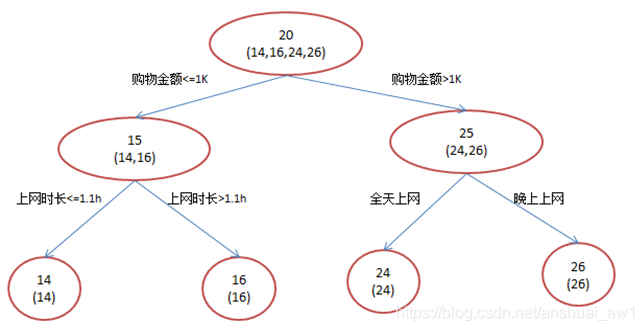
2）但是如果用GBDT来做这件事，由于数据太少，我们限定叶子节点最多有两个，即每棵树都只有一个分枝，并且限定只限定两棵树。我们会得到如下所示结果：

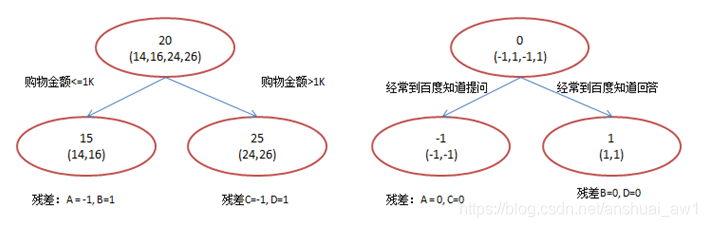

第一棵树的分枝与之前一样，也是使用购物金额进行区分，两拨人各自用年龄均值作为预测值，得到残差值-1、1、-1、1，然后拿这些残差值替换初始值去训练生成第二棵回归树，如果新的预测值和残差相等，则只需把第二棵树的结论累加到第一棵树上就能得到真实年龄了。

第二棵树只有两个值1和-1，直接可分成两个节点。此时所有人的残差都是0，即每个人都得到了真实的预测值。


3）将两棵回归树预测结果进行汇总，解释如下：

    - A：14岁高一学生；购物较少；经常问学长问题；预测年龄A = 15 – 1 = 14
    - B：16岁高三学生；购物较少；经常被学弟问问题；预测年龄B = 15 + 1 = 16
    - C：24岁应届毕业生；购物较多，经常问师兄问题；预测年龄C = 25 – 1 = 24
    - D：26岁工作两年员工；购物较多，经常被师弟问问题；预测年龄D = 25 + 1 = 26

对比初始的回归树与GBDT所生成的回归树，可以发现，最终的结果是相同的，那我们为什么还要使用GBDT呢？

答案就是对模型过拟合的考虑。过拟合是指为了让训练集精度更高，学到了很多“仅在训练集上成立的规律”，导致换一个数据集后，当前规律的预测精度就不足以使人满意了。毕竟，在训练精度和实际精度（或测试精度）之间，后者才是我们想要真正得到的。

在上面这个例子中，初始的回归树为达到100%精度使用了3个特征（上网时长、时段、网购金额），但观察发现，分枝“上网时长>1.1h”很显然过拟合了，不排除恰好A上网1.5h, B上网1小时，所以用上网时间是不是>1.1小时来判断所有人的年龄很显然是有悖常识的。

而在GBDT中，两棵回归树仅使用了两个特征（购物金额与对百度知道的使用方式）就实现了100%的预测精度，其分枝依据更合乎逻辑（当然这里是相比较于上网时长特征而言），算法在运行中也体现了“如无必要，勿增实体”的奥卡姆剃刀原理。


### 3.3 提升树实例
下表为训练数据，$x$的取值范围为区间$[0.5,10.5]$，y yy的取值范围为区间$[5.0,10.0]$，学习这个回归问题的提升树模型，考虑只用二叉树作为基函数：

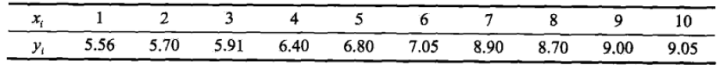

(1)步骤一：求$f_1(x)$即回归树$T_1(x)$
首先通过以下优化问题：
    
$$
\min _{s}\left[\min _{c_{1}} \sum_{x_{i} \in R_{1}}\left(y_{i}-c_{1}\right)^{2}+\min _{c_{2}} \sum_{x_{i} \in R_{2}}\left(y_{i}-c_{2}\right)^{2}\right]
$$

求解训练数据的切分点$s$：
$$
R_{1}=\{x \mid x \leq s\}, R_{2}=\{x \mid x>s\}
$$

容易求得在$R_1,R_2$内部使平方误差达到最小值的$c_1,c_2$为

$$
\begin{aligned}
&c_{1}=\frac{1}{N_{1}} \sum_{x_{i} \in R_{1}} y_{i} \\
&c_{2}=\frac{1}{N_{2}} \sum_{x_{i} \in R_{2}} y_{i}
\end{aligned}
$$
其中$N_1,N_2是R_1,R_2的样本点数$。

具体地，求解训练数据的切分点。根据所给数据，考虑如下切分点：
$$
1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5
$$
对各切分点，不难求出相应的$$R_1,R_2,c_1,c_2及

$$
m(s)=\min _{c_{1}} \sum_{x_{i} \in R_{1}}\left(y_{i}-c_{1}\right)^{2}+\min _{c_{2}} \sum_{x_{i} \in R_{2}}\left(y_{i}-c_{2}\right)^{2}
$$
例如，当$s=2.5时$

$$
\begin{aligned}
&R_{1}=\{1,2\}, \quad R_{2}=\{3,4, \cdots, 9,10\}, \quad c_{1}=5.63, c_{2}=7.73 \\
&m(s)=\min _{c_{1}} \sum_{x_{i} \in R_{1}}\left(y_{i}-c_{1}\right)^{2}+\min _{c_{2}} \sum_{x_{i} \in R_{2}}\left(y_{i}-c_{2}\right)^{2}=12.07
\end{aligned}
$$

遍历所有的$s$，计算$m(s)$，结果列表如下：

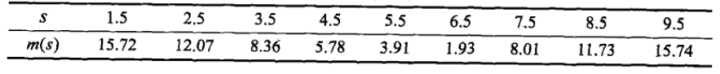
可知当$s=6.5$时$m(s)$达到最小值，此时

$$
R_1 = {1,2,\ldots,6},R_2 = {7,8,9,10},c_1 = 6.24, c_2 = 8.91
$$
所以回归树$T_1(x)$为

$$
\begin{gathered}
T_{1}(x)= \begin{cases}6.24 & x<6.5 \\
8.91 & x \geqslant 6.5\end{cases} \\
f_{1}(x)=T_{1}(x)
\end{gathered}
$$

$用f_1(x)拟合训练数据的残差，表中r_{2i} = y_i-f_1(x_i)$

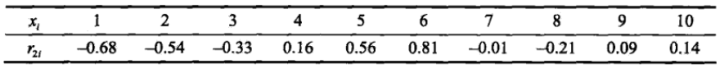
平方损失误差为：
$$
L\left(y, f_{1}(x)\right)=\sum_{i=1}^{10}\left(y_{i}-f_{1}\left(x_{i}\right)\right)^{2}=1.93
$$

(2) 步骤二：求$T_2(x)$，方法与求$T_1(x)$一样，只是拟合的数据是上一步得到的残差,可以得到：
$$
\begin{gathered}
T_{2}(x)=\left\{\begin{array}{cc}
-0.52 & x<3.5 \\
0.22 & x \geqslant 3.5
\end{array}\right. \\
f_{2}(x)=f_{1}(x)+T_{2}(x)=\left\{\begin{array}{lc}
5.72 \quad x<3.5 \\
6.46 & 3.5 \leq x<6.5 \\
9.13 & x \geqslant 6.5
\end{array}\right.
\end{gathered}
$$

用$f_2(x)$拟合训练数据的平方误差是
$$
L\left(y, f_{2}(x)\right)=\sum_{i=1}^{10}\left(y_{i}-f_{2}\left(x_{i}\right)\right)^{2}=0.79
$$

继续迭代


$$
\begin{aligned}
&T_{3}(x)=\left\{\begin{array}{cc}
0.15 & x<6.5 \\
-0.22 & x \geqslant 6.5
\end{array} \right. -----L\left(y, f_{3}(x)\right)=0.47\\
&T_{4}(x)=\left\{\begin{array}{cc}
-0.16 & x<4.5 \\
0.11 & x \geqslant 4.5
\end{array} \right. -----L\left(y, f_{4}(x)\right)=0.3 \\ 
&T_{5}(x)=\left\{\begin{array}{cc}
0.07 & x<6.5 \\
-0.11 & x \geqslant 6.5
\end{array} \right. -----L\left(y, f_{5}(x)\right)=0.23
\end{aligned}
$$

$$
\begin{gathered}
T_{6}(x)=\left\{\begin{array}{cc}
-0.15 & x<2.5 \\
0.04 \quad & x \geqslant 2.5
\end{array}\right. \\
f_{6}(x)=f_{5}(x)+T_{6}(x)=T_{1}(x)+\cdots+T_{5}(x)+T_{6}(x) \\
=\left\{\begin{array}{cc}
5.63 \quad x<2.5 \\
5.82 \quad 2.5 \leq x<3.5 \\
6.56 \quad 3.5 \leq x<4.5 \\
6.83 & 4.5 \leq x<6.5 \\
8.95 \quad x \geq 6.5
\end{array}\right.
\end{gathered}
$$

用$f_6(x)$拟合训练数据的平方损失误差是
$$
L\left(y, f_{1}(x)\right)=\sum_{i=1}^{10}\left(y_{i}-f_{1}\left(x_{i}\right)\right)^{2}=0.17
$$
假设此时已满足误差要求，那么$f(x) = f_6(x)$即为所求提升树

## 四、Gradient Boosting Decision Tree：梯度提升决策树
### 4.1 GBDT简介
提升树利用加法模型与前向分布算法实现学习的优化过程，即是通过迭代得到一系列的弱分类器，进而通过不同的组合策略得到相应的强学习器。在GBDT的迭代中，假设前一轮得到的学习器为$f_{t-1}(x)$对应的损失函数则为$L(y,f_{t-1}(x))$。因此新一轮迭代的目的就是找到一个弱分类器$h_t(x)$，使得损失函数$L(y,f_{t-1}(x)+h_t(x))$达到最小。

因此问题的关键就在于对损失函数的度量，这也正是难点所在。当损失函数是平方损失和指数损失时，每一步优化是很简单的。但对一般损失函数而言，往往每一步优化没那么容易，如绝对值损失函数和Huber损失函数。常见的损失函数及其梯度如下表所示：

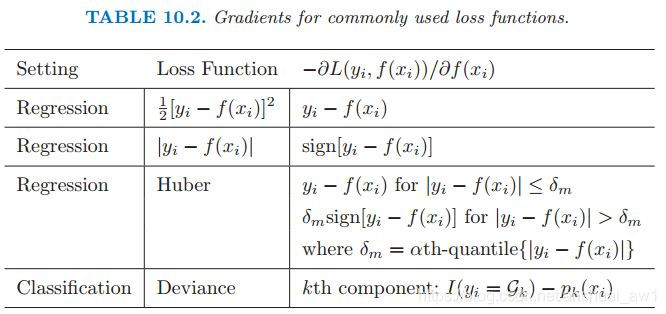

那我们怎么样才能找到一种通用的拟合方法呢？

针对这一问题，Freidman提出了梯度提升算法：利用最速下降的近似方法，即利用损失函数的负梯度在当前模型的值

$$
-\left[\frac{\partial L\left(y, f\left(x_{i}\right)\right)}{\partial f\left(x_{i}\right)}\right]_{f(x)=f_{m-1}(x)}
$$

作为回归问题中提升树算法的残差的近似值（与其说负梯度作为残差的近似值，不如说残差是负梯度的一种特例，拟合一个回归树），这就是梯度提升决策树。

### 4.2 GBDT算法步骤

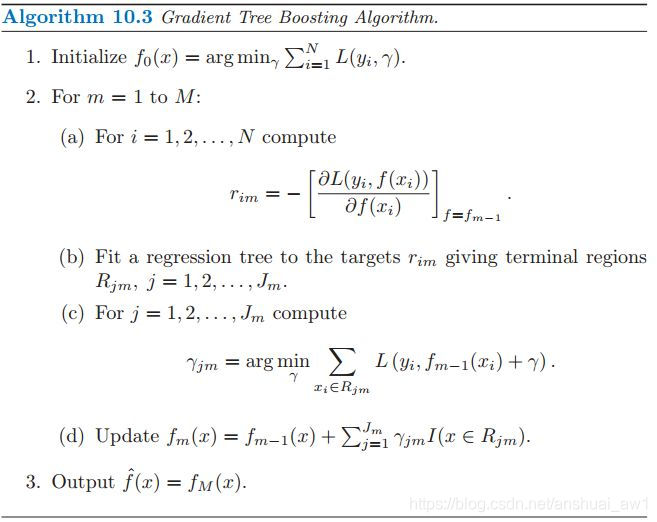

接下来对上图中的算法步骤进行详细解释：

1) 初始化弱分类器，估计使损失函数极小化的一个常数值，此时树仅有一个根结点

$$
f_{0}(x)=\arg \min _{c} \sum_{i=1}^{N} L\left(y_{i}, c\right)
$$

2) 对迭代轮数$1,2,\ldots,M(即产生树的个数为M)$
    - a) 对$i=1,2,\ldots,N(N个样本)$，计算损失函数的负梯度值在当前模型的值，将它作为残差的估计。即
$$
r_{m i}=-\left[\frac{\partial L\left(y, f\left(x_{i}\right)\right)}{\partial f\left(x_{i}\right)}\right]_{f(x)=f_{m-1}(x)}
$$

对于平方损失函数，它就是通常所说的残差；对于一般损失函数，它就是残差的近似值。
    - b) 对$\gamma_{mi}$拟合一个回归树，得到第$m$颗树的叶结点区域$R_{mj}, j=1,2,\ldots,J$
    - c) 对$j = 1,2,\ldots,J$计算
$$
c_{m j}=\arg \min _{c} \sum_{x_{i} \in R_{m j}} L\left(y_{i}, f_{m-1}\left(x_{i}\right)+c\right)
$$

即利用线性搜索估计叶结点区域的值，使损失函数极小化。

    - d) 更新回归树
$$
f_{m}(x)=f_{m-1}(x)+\rho \sum_{j=1}^{J} c_{m j} I\left(x \in R_{m j}\right)
$$

$I(x)$为Indicator函数，即样本$x$属于哪个叶节点，即加上这个叶节点的$c_{mj}$。在这里，其实应该有$\rho$，只不过图中没有标注而已，具体在4.3节例子中可以看到。

3) 得到输出的最终模型

$$
\hat{f}(x)=f_{M}(x)=\rho \sum_{m=1}^{M} \sum_{j=1}^{J} c_{m j} I\left(x \in R_{m j}\right)
$$

**NOTE: 在这里，需要仔细解释下上述算法的注意事项：**

①对于算法的2.(a)步，损失函数选择使用：
$L(y_i,f(x_i)) = (1/2)\*(y_i-f(x_i))^2$，那么其负梯度值为：$-\left[\frac{\partial L\left(y_{i}, f\left(\mathbf{x}_{i}\right)\right)}{\partial f\left(\mathbf{x}_{i}\right)}\right]=\left(y_{i}-f\left(x_{i}\right)\right)$，再带入当前模型的值$f(x) = f_{m-1}(x)$，则有：

$$
\tilde{y}_{i}=-\left[\frac{\partial L\left(y_{i}, f\left(\mathbf{x}_{i}\right)\right)}{\partial f\left(\mathbf{x}_{i}\right)}\right]_{f(x)=f_{m-1}(x)}=\left(y_{i}-f_{m-1}\left(x_{i}\right)\right)
$$

关于如何推导logistic loss的梯度，在接下来会展示。
②对于算法的2.（b）步，对于决策树，寻找一个最优的树的过程其实依靠的就是启发式的分裂准则。

③对于算法的2.（c）步，我们得到叶子节点对应的区域，那么叶子节点的取值为多少？也就是这颗树到底输出多少？

在Friedman的论文中有这部分的推导。这里简单总结一下：

叶子节点的取值和所选择的loss function有关。对于不同的Loss function，叶子节点的值也不一样。

首先，记第m mm颗树的第j jj个叶子节点的值为$c_{jm}$
比如，选择MSE作为loss function时：
$$
c_{jm} = ave_{xi\in R_{jm} \tilde{y_i}}
$$
\tilde{y_i}为梯度值
比如，选择MAE作为Loss function时：
$$
c_{jm} = median_{xi\in R_{jm} (y_i - f_{m-1}(x_i)}
$$
比如，选择Logistic loss作为Loss function时：
$$
c_{j m}=\frac{\sum_{i=1}^{N} \tilde{y}_{i}}{\sum_{i=1}^{N}\left(y_{i}-\tilde{y}_{i}\right) *\left(1-y_{i}+\tilde{y}_{i}\right)}
$$

比如，选择指数损失作为loss function时：
$$
c_{j m}=\frac{\sum_{i=1}^{N}\left(2 y_{i}-1\right) e^{\left(-\left(2 y_{i}-1\right) f_{m-1}\left(x_{i}\right)\right)}}{\sum_{i=1}^{N} e^{\left(-\left(2 y_{i}-1\right) f_{m-1}\left(x_{i}\right)\right)}}
$$

这些叶子节点的取值推导过程在论文中其实也只是几笔带过，有兴趣的可以深入研究为何。

④对于算法的2.（d）步，在GBDT里，通常将这个过程作为Shrinkage，也就是把ρ \rhoρ做为学习率，后面实践部分可以看到效果。

⑤一个特别细节的问题是，在1)步，根节点$f_0(x)$的初始值怎么设定：什么需要初始化？很简单，因为每次在计算负梯度值时需要用到前一个模型$f_{m−1}(x_i)$预测的值。对于我们训练的第一个模型$m=1$而言需要有$f_0(x_i)$的存在。

那么$f_0(x_i)$初始化为多少？这个取决于loss function的选择，下面给出一般的做法：

当loss function选择MSE时，$f_0(x)=\bar{y}$
为样本真实值的平均值。比如有数据集：
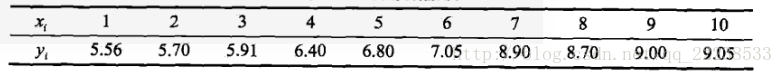

那么$f_0(x)=\bar{y}=7.306$

当loss function选择MAE时，$f_0(x)=median_y$，也就说用真实值的中位数作为初始值。
当loss function选择logisit loss时，$f_0(x)=(\frac{1}{2})*log(\frac{\sum y_i}{\sum(1-y_i)})$

这里需要注意的是，这里就是利用对数几率来初始化，分子$\sum{y_i}$ 
就是正样本的个数，分母就是负样本的个数。
比如说，对于数据集：
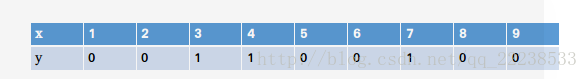

$f_0(x)=(\frac{1}{2})*log(\frac{\sum y_i}{\sum(1-y_i)})=(\frac{1}{2})*log(\frac{3}{7})$ 

另外，再介绍一个Loss function，指数损失。具体表达为：$\large L\left(y_i,f(x_i)\right)=e^{-yf(x_i)}$其负梯度大家可以求求。其初始化和上面提到Logisit loss的初始化是一样的。

### 4.3 GBDT实例

在介绍完GBDT的训练过程和细节后，可能大家还有些懵。我们举例来说明GBDT的训练过程，可以清晰地看明白过程。为了方便说明，我们用下面这个很简单的数据。

|x_i|1|2|3|4|5|6|7|8|9|10|
|---|---|---|---|---|---|---|---|---|---|---|
|y_i|5.56|5.7|5.91|6.4|6.8|7.05|8.9|8.7|9|9.05|


1.选择MSE做为建树的分裂准则

2.选择MSE作为误差函数

3.树的深度设置为1

(1)步骤一：根据GBDT算法，我们需要初始化$f_0(x)$，MSE使用均值作为初始化，因此$f_0(x)=7.307$ 
(2)步骤二：拟合第一颗树$(m=1)$

由公式，可以计算负梯度值：
$$
\tilde{y}_{i}=-\left[\frac{\partial L\left(y_{i}, f\left(\mathbf{x}_{i}\right)\right)}{\partial f\left(\mathbf{x}_{i}\right)}\right]_{f(x)=f_{m-1}(x)}=\left(y_{i}-f_{m-1}\left(x_{i}\right)\right)
$$

具体结果如下表：
								
|x_i|1|2|3|4|5|6|7|8|9|10|
|---|---|---|---|---|---|---|---|---|---|---|
|y_i|-1.747|-1.607|-1.397|-0.907|-0.507|-0.257|1.593|1.393|1.693|1.743|


得到梯度值后，下面就是以$\tilde{y_i}$
 为目标值进行拟合。

这里简单回顾一下决策树建树的过程：

决策树学习最关键的步骤就是选择最优划分属性，一般而言，随着划分过程不断的进行，我们希望决策树的分支节点所包含的样本尽可能属于同一类别（方差小）。通常，我们会选择一个准则来评价划分的质量，比如回归树中经常使用的MSE（这种方法属于启发式的）

对于连续值，我们可以穷尽每个值$v$，把每个值$v$作为一个分裂点$(<=v和>v)$,然后计算两个分支的$MSE_{left}$、$MSE_{right}$。选择最小的M$MSE_{sum}=MSE_{left}+MSE_{right}$的分裂点$v$。当然关于连续值，也可以把属性值从小到大排序，选择每2个值的中值进行判断。

对于类别型特征，我们有类似的做法，通过$=$和≠来划分。

当选择1作为分裂点时候，4MSE_{left}=0MSE_{right}=1.747#

当选择2作为分裂点时候，$MSE_{left}=0.0049, $MSE_{right}=1.5091

依次，穷尽所有取值。

可以得到，当选择6作为分裂点时$MSE_{sum}=0.3276$
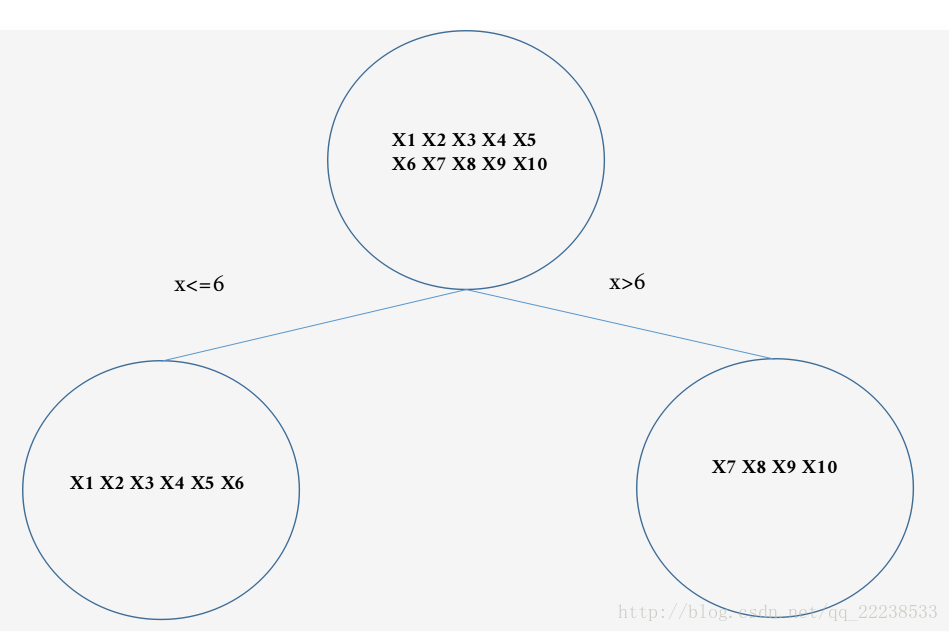

至此，我们完成了第一颗树的拟合，拟合完之后我们得到了$R_{jm}$
 以及$c_{jm}$,具体为：
$$
\begin{gathered}
R_{11} \text { 为 } x_{i}<=6, R_{21} \text { 为 } x_{i}>6 \\
c_{11}=\frac{\left(\tilde{y}_{1}+\tilde{y}_{2}+\tilde{y}_{3}+\tilde{y}_{4}+\tilde{y}_{5}+\tilde{y}_{6}\right)}{6}=-1.0703 \\
c_{21}=\frac{\left(\tilde{y}_{7}+\tilde{y}_{8}+\tilde{y}_{9}+\tilde{y}_{10}\right)}{4}=1.6055
\end{gathered}
$$

最后更新$f_1(x_i)$值，$f_1(x_i) = f_0(x_i)+\sum_{j=1}^2 c_{j1}I(x_i \in R_{j1})$。

这里需要注意的是，算法2.（d）我们提到一个算法步骤是Shrinkage。在GBDT里，我们通过不会直接把上一个轮的预测值$f_{m-1}(x)$直接加上$\sum_{j=1}^J c_{jm}I(x_i \in R_{jm})$，而是会在$\sum_{j=1}^J c_{jm}I(x_i \in R_{jm})$乘上一个学习率。可以理解，因为如果每次完全加上（学习率为1）本轮模型的预测值容易导致过拟合。所以通常在GBDT中的做法是：
$f_{m}(x) = f_{m-1}(x)+ \rho * \sum_{j=1}^J c_{jm}I(x_i \in R_{jm})$。$\rho$为学习率。所以，当$\rho = 0.1时$，上面的计算结果变为
$f_{1}(x_1) = f_{0}(x_1)+ 0.1 * \sum_{j=1}^2 c_{j1}I(x_1 \in R_{j1}) = 7.037 -0.1*1.0703 = 7.19997$

至此一轮迭代（第一个颗树拟合）完成，下面开始第二轮迭代（第二颗树拟合）。

（3）步骤三：拟合第二颗树$(m=2)$
比如，这里示范计算$\tilde{y}_1$

$$
\tilde{y_{1}}=-\left[\frac{\partial L\left(y_{i}, f\left(\mathbf{x}_{i}\right)\right)}{\partial f\left(\mathbf{x}_{i}\right)}\right]_{f(x)=f_{m-1(x)}}=\left(y_{1}-f_{1}\left(x_{1}\right)\right)=(5.56-7.19997)=-1.63997
$$

其他由公式计算可以得到下表：

|x_i|1|2|3|4|5|6|7|8|9|10| \\
|---|---|---|---|---|---|---|---|---|---|---|
|y_i|-1.63997|-1.49997|-1.28997|-0.79997|-0.39997|-0.149967|1.43245|1.23245|1.53245|1.58245|

因此，在第二颗树中，拟合的是新的梯度值。下面的过程就是建树->计算叶子节点的值、叶子节点的区间->更新$f_2(x)$。所以就不在累述了。

$$
c12 = -0.9633
c22 = 1.44495
$$

最后，我们来看一下如何进行预测。

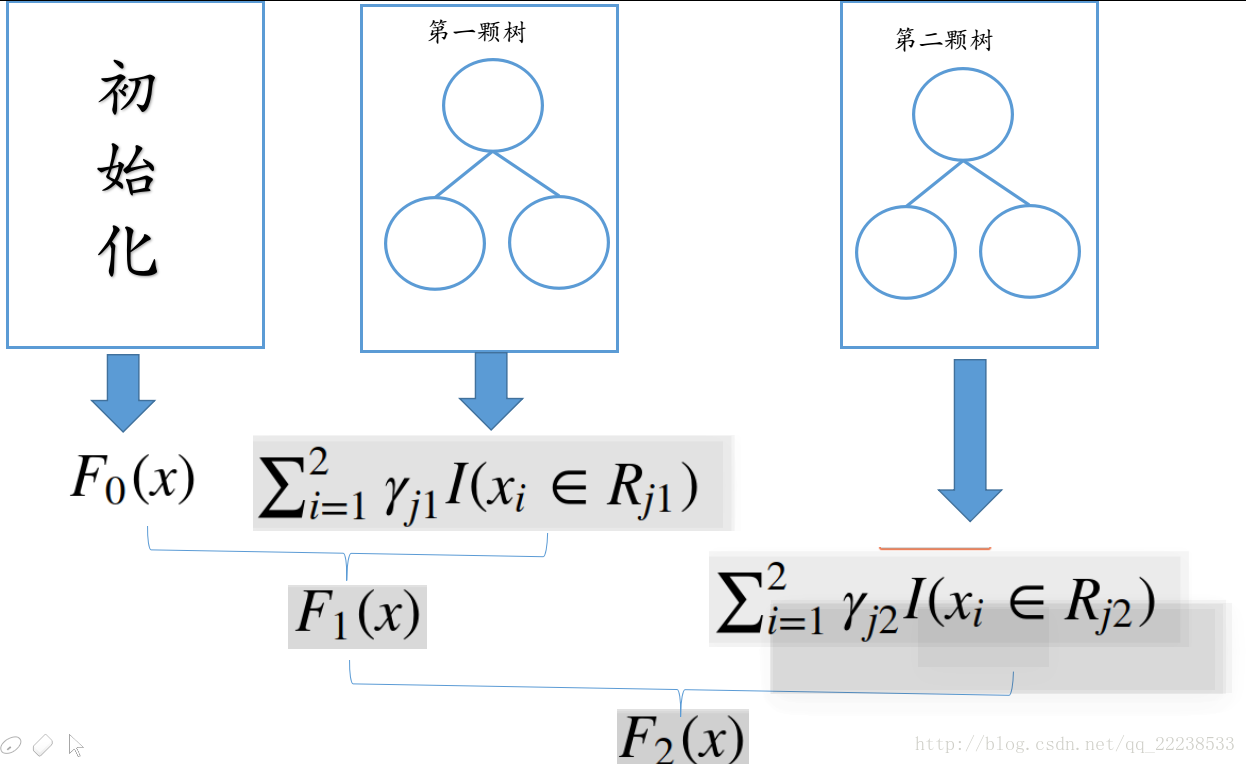

图里的$\gamma$即为$c$，$F()$即为$f()$。

在这里有必要再解释一下预测过程：如果要预测一个新的样本$x$，且此时只训练出两个树，则预测的值为$f_2(x)$，并非是$f_0(x)+f_1(x)+f_2(x)$。这是显然的：因为在每一个$f_m(x)$中都已经是在$f_{m-1}(x)$的基础上得来的。或者说，在GBDT中，每一个样本都一定会出现在每一颗树的某个叶子节点中，把所有的叶子节点的值相加就是这个样本预测的值。

这篇文章也有一个GBDT做回归的例子，感兴趣的读者可以去读下再次加深印象。


## 五、总结
我们来简单的总结一下。

回头看，其实GBDT的思路是很简单的，每一次用一个回归树来拟合一个梯度值。而这个梯度值就只是损失函数的一阶导数在当前模型的取值。拟合完一颗树之后，需要计算叶子节点的值，而这个值是和损失函数有关的，当然，数学大神们已经为我们计算好常用的一些损失函数的叶子节点取值。最终预测结果其实就是每一颗树的预测结果相加，所以整个过程都非常的好理解。即为：初始化->计算负梯度值->用回归树拟合负梯度值->计算叶子节点值->更新$f_m(x)$



## 六、细节Q&A
### 6.1 GBDT根节点的初始值怎么设定？
与损失函数有关，本篇4.2.Note.⑤中有介绍。

### 6.2 GBDT叶子节点的取值为多少？
与损失函数有关，本篇4.2.Note.③中有介绍。

### 6.3 GBDT如何做二分类？
前几章介绍的是如何做回归，那么GBDT如何做二分类呢？相信，大多数小伙伴都不是特别清楚。因此，这里单独把GBDT如何做二分类作为一个问题来讲解。

### 6.3.1 Logistic loss损失

分类任务的GBDT算法过程其实与回归过程的算法过程几乎没有区别，只不过其中选用的loss function是Logistic loss：

$$
L\left(y_{i}, f_{m}\left(x_{i}\right)\right)=-\left\{y_{i} \log p_{i}+\left(1-y_{i}\right) \log \left(1-p_{i}\right)\right\}
$$
其中，$p_i = \frac{1}{1+e^{-f_m(x)}}$

这里简单推导一下logloss通常化简后的式子：
代入 $p_{i}=y_{i} \log \left(\frac{1}{\left.1+e^{\left(-f_{m}\left(x_{i}\right) t\right.}\right)}\right)+\left(1-y_{i}\right) \log \left(\frac{e^{\left(-f_{m}\left(x_{i}\right)\right)}}{1+e^{\left(-f_{m}\left(x_{i}\right)\right)}}\right)$
$\Rightarrow-y_{i} \log \left(1+e^{\left(-f_{m}\left(x_{i}\right)\right)}\right)+\left(1-y_{i}\right)\left\{\log \left(e^{\left(-f_{m}\left(x_{i}\right)\right)}\right)-\log \left(1+e^{\left(-f_{m}\left(x_{i}\right)\right)}\right\}\right.$
$\Rightarrow-y_{i} \log \left(1+e^{\left(-f_{m}\left(x_{i}\right)\right)}\right)+\log \left(e^{\left(-f_{m}\left(x_{i}\right)\right)}\right)-\log \left(1+e^{\left(-f_{m}\left(x_{i}\right)\right)}\right)-y_{i} \log \left(e^{\left(-f_{m}\left(x_{i}\right)\right)}\right)$
$+y_{i} \log \left(1+e^{\left(-f_{m}\left(x_{i}\right)\right)}\right)$
$\Rightarrow y_{i} f_{m}\left(x_{i}\right)-\log \left(1+e^{f_{m}\left(x_{i}\right)}\right)$ \\
最后加上负号可以得:
$$
L\left(y_{i}, f_{m}\left(x_{i}\right)\right)=-\left\{y_{i} \log p_{i}+\left(1-y_{i}\right) \log \left(1-p_{i}\right)\right\}=-\left\{y_{i} f_{m}\left(x_{i}\right)-\log \left(1+e^{f_{m}\left(x_{i}\right)}\right)\right\}
$$
对上述公式求导，则
$$
\tilde{y}_{i}=-\left[\frac{\partial L\left(y_{i}, f\left(\mathbf{x}_{i}\right)\right)}{\partial f\left(\mathbf{x}_{i}\right)}\right]_{f(x)=f_{m-1}(x)}=y_{i}-\frac{1}{1+e^{-f_{m-1}\left(x_{i}\right)}}
$$
这就是logloss负梯度的公式。


### 6.3.2 算法流程
    ![image.png](attachment:image.png)
    
可以看出来，GBDT用于做二分类与做回归没有什么流程上的区别，只是初始节点、叶子节点和负梯度不同而已，这是因为采用的损失函数不同。

### 6.3.3 二分类实例
下面同样以一个简单的数据集来大致的介绍一下GBDT做二分类的过程。

|x_i|1|2|3|4|5|6|7|8|9|10| 
|---|---|---|---|---|---|---|---|---|---|---|
|y_i|0|0|0|1|1|0|0|0|1|1|

参数配置：

    1.以logloss为损失函数

    2.**以MSE为分裂准则 （与做回归时采用的相同）**

    3.树的深度为1

    4.学习率为0.1
    
 （1）步骤一：初始化。$f-0 = log(\frac{\sum_{i=1}^N y_i}{\sum_{i=1}^N(1-y_i) = log(\frac{4}{6} = -0.4054(这里少乘了\frac{1}{2})$
 （2）步骤二：拟合第一棵树$(m=1)$
 
 计算负梯度值：
 $$
\tilde{y}_{i}=-\left[\frac{\partial L\left(y_{i}, f\left(\mathbf{x}_{i}\right)\right)}{\partial f\left(\mathbf{x}_{i}\right)}\right]_{f(x)=f_{m-1}(x)}=y_{i}-\frac{1}{\left.1+e^{\left(-f_{m-1}\left(x_{i}\right)\right.}\right)}=y_{i}-\frac{1}{1+e^{\left(-f_{0}\left(x_{i}\right)\right)}}
$$

比如计算第一个样本$(i=1)$有：
$$
\tilde{y}_i = 0 - \frac{1}{1+e^{0.4054}} = -0.4
$$

同样的，其他计算后如下表：

|x_i|1|2|3|4|5|6|7|8|9|10| 
|---|---|---|---|---|---|---|---|---|---|---|
|y_i|-0.4|-0.4|-0.4|-0.6|-0.6|-0.4|-0.4|-0.4|-0.6|-0.6|

着，我们需要以$\tilde{y_i}$
 为目标，拟合一颗树。

拟合树的过程在介绍GBDT做回归时已经详细介绍了，这里就不再累述了。拟合完后结果如下：
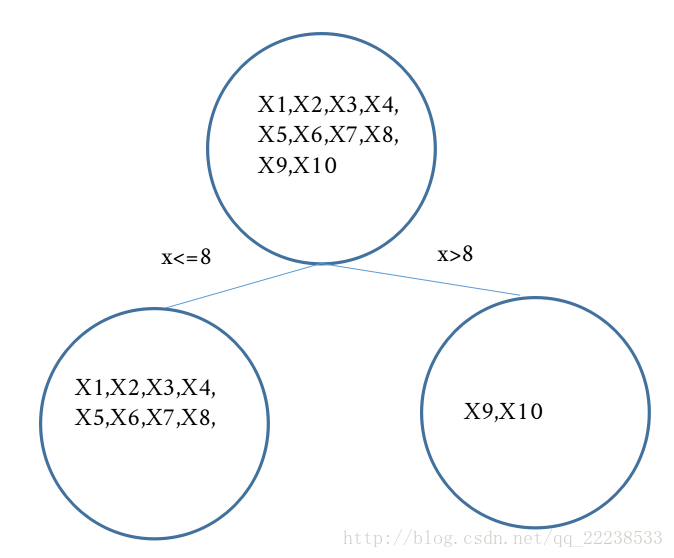

可以得出建好树之后叶子节点的区域：
$$R_{11}为x_i <= 8,R_{21}为x_i > 8$$
下面可以计算出叶子节点的值$c_{jm}$
由公式:

$$
c_{j m}=\frac{\sum_{x_{i} \in R_{j m}} \tilde{y}_{i}}{\sum_{x_{i} \in R_{j m}}\left(y_{i}-\tilde{y}_{i}\right) *\left(1-y_{i}+\tilde{y}_{i}\right)}
$$
对于区域 $R_{11}$ 有如下
$$
\sum_{x_{i} \in R_{11}} \tilde{y}_{i}=\left(\tilde{y}_{1}+\tilde{y}_{2}+\tilde{y}_{3}+\tilde{y}_{4}+\tilde{y}_{5}+\tilde{y}_{6}+\tilde{y}_{7}+\tilde{y}_{8}\right)=-1.2
$$
$$
\sum_{x_{i} \in R_{11}}\left(y_{i}-\tilde{y}_{i}\right) *\left(1-y_{i}+\tilde{y}_{i}\right)=\left(y_{1}-\tilde{y}_{1}\right) *\left(1-y_{1}+\tilde{y}_{1}\right)+\left(y_{2}-\tilde{y}_{2}\right) *\left(1-y_{2}+\tilde{y}_{2}\right)+\left(y_{3}-\tilde{y}_{3}\right) *
$$ $\left(1-y_{3}+\tilde{y}_{3}\right)+\left(y_{4}-\tilde{y}_{4}\right) *\left(1-y_{4}+\tilde{y}_{4}\right)+\left(y_{5}-\tilde{y}_{5}\right) *\left(1-y_{5}+\tilde{y}_{5}\right)+\left(y_{6}-\tilde{y}_{6}\right) *\left(1-y_{6}+\tilde{y}_{6}\right)+\left(y_{7}-\right.$ $\left.\tilde{y}_{7}\right) *\left(1-y_{7}+\tilde{y}_{7}\right)+\left(y_{8}-\tilde{y}_{8}\right) *\left(1-y_{8}+\tilde{y}_{8}\right)=1.92$

对于区域 $R_{21}$ 有如下:
$$
\sum_{x_{i} \in R_{21}} \tilde{y}_{i}=\left(\tilde{y}_{9}+\tilde{y}_{10}\right)=1.2
$$
$$
\sum_{x_{i} \in R_{21}}\left(y_{i}-\tilde{y}_{i}\right) *\left(1-y_{i}+\tilde{y}_{i}\right)=\left(y_{9}-\tilde{y}_{9}\right) *\left(1-y_{9}+\tilde{y}_{9}\right)+\left(y_{10}-\tilde{y}_{10}\right) *\left(1-y_{10}+\tilde{y}_{10}\right)=0.48
$$
故最后可以得到两个叶子节点的值:
$$
c_{11}=\frac{-1.2}{1.92}=-0.625, c_{21}=\frac{1.2}{0.480}=2.5
$$
最后通过 $f_{m}(x)=f_{m-1}(x)+\sum_{j=1}^{J} c_{j m} I\left(x \in R_{j m}\right)$ 更新 $f_{1}(x)$ ，需要注意的是，这里同样也用shrinkage，即乘一个 学习率 $\rho$ ，具体表现为:
$$
f_{m}(x)=f_{m-1}(x)+\rho * \sum_{j=1}^{J} c_{j m} I\left(x \in R_{j m}\right)
$$

以计算 $x_{1}$ 为例：
$$
f_{1}\left(x_{1}\right)=f_{0}\left(x_{1}\right)+0.1 *(-0.625)=-0.4054-0.0625=-0.4679
$$
其他计算完毕后如下表供参考:

|x_i|1|2|3|4|5|6|7|8|9|10| 
|---|---|---|---|---|---|---|---|---|---|---|
|y_i|-0.46797|-0.46797|-0.46797|-0.46797|-0.46797|-0.46797|-0.46797|-0.46797|-0.15547|-0.15547|

至此，第一颗树已经训练完成。可以再次看到其训练过程和回归基本没有区别。
(3) 步骤三: 拟合第二颗树 $(m=2)$
计算负梯度值:
比如对于 $x_{1}$ 有:
$$
\tilde{y}_{1}=y_{1}-\frac{1}{\left.1+e^{\left(-f_{1}\left(x_{1}\right)\right.}\right)}=0-0.38509=-0.38509
$$

其他同理，可得下表：

|x_i|1|2|3|4|5|6|7|8|9|10| 
|---|---|---|---|---|---|---|---|---|---|---|
|y_i|-0.3851|-0.3851|-0.3851|0.6149|0.6149|-0.46797|-0.46797|-0.46797|0.5388|0.5388|

之后也是以新的 $\tilde{y}_{i}$ 为目标拟合一颗回归树后计算叶子节点的区间和叶子节点的值。
NOTE:相比于回归任务，分类任务需把要最后累加的结果 $f_{m}(x)$ 转成概率。(其实 $f_{m}(x)$ 可以理解成一个得分) 。具体来 说:
对于采用logloss作为损失函数的情况下， $p_{i}=\frac{1}{1+e^{\left(-f_{m}\left(x_{i}\right)\right)}}$
对于采用指数损失作为损失函数的情况下， $p_{i}=\frac{1}{1+e^{\left(-2 f_{m}\left(x_{i}\right)\right)}}$
当然抆里的 $p_{i}$ 指的是正样本的概率。
这里再详细一点，比如对于上面例子，当我们拟合完第二颗树后，计算 $f_{2}(x)$ 可有下表:

|x_i|1|2|3|4|5|6|7|8|9|10| 
|---|---|---|---|---|---|---|---|---|---|---|
|y_i|-0.52501|-0.52501|-0.52501|-0.52501|-0.52501|-0.525017|-0.52501|-0.52501|0.06136|0.06136|

此时计算相应的概率值有：$f_2(x)$可有下表：

|x_i|1|2|3|4|5|6|7|8|9|10| 
|---|---|---|---|---|---|---|---|---|---|---|
|y_i|0.3717|0.3717|0.37171|0.3717|0.3717|0.3717|0.3717|0.3717|0.5153|0.5153|

表中的概率为正样本的概率，即$y_i=1$的概率。


### 6.4 GBDT如何做多分类？
有了前面GBDT做回归和二分类的经验之后，那么GBDT做多分类的思路也是水到渠成的了。

#### 6.4.1 算法流程
下图是Friedman在论文中对GBDT多分类给出的伪代码

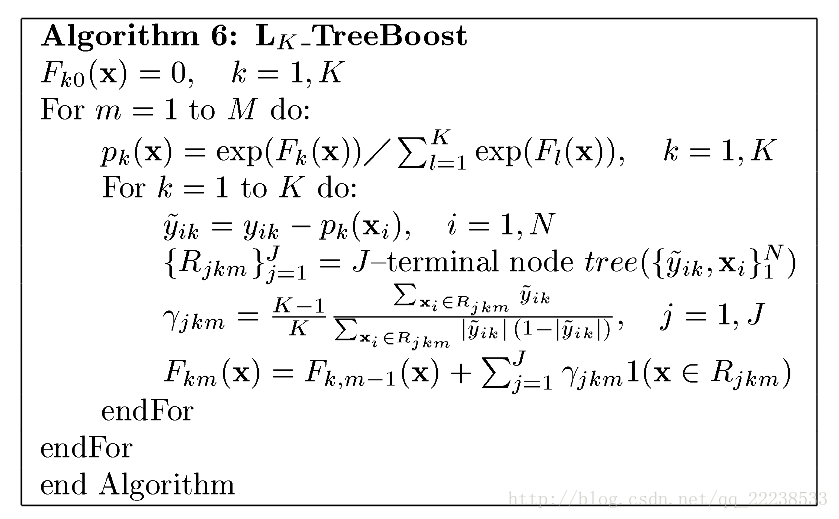

从代码上看，大致和分类时候的过程一样。最大的不同点在于多了一层内部的循环For。
这里需要注意的是:
1.对于多分类任务，GDBT的做法是采用一对多的策略 (详情见文章)。
也就是说，对每个类别训练 $M$ 个分类器。假设有 $K$ 个类别，那么训练完之后总共有 $M^{*} K$ 颗树。
2.两层循环的顺序不能改变。也就是说，K个类别都拟合完第一颗树之后才开始拟合第二颗树，不允许先把某一个类别的 $M$ 颗树学习完，再学习另外一个类别。
算法 6 使用的是多分类常用的损失函数:
$$
L\left(\left\{y_{k}, f_{k}(x)\right\}_{1}^{K}\right)=-\sum_{k=1}^{K} y_{k} \log _{k}(x)
$$
其中， $p_{k}(x)=\frac{e^{f_{k}(x)}}{\sum \sum^{\hat{1}} e^{e^{\dagger(}(x)}}$
对损失函数求一阶导有:

$$
\tilde{y}_{i k}=-\left[\frac{\partial L\left(\left\{y_{i l}, f_{l}(x)\right\}_{l=1}^{K}\right)}{\partial f_{k}\left(x_{i}\right)}\right]_{\left\{f_{l}(x)=f_{l, m-1}(x)\right\}_{1}^{K}}=y_{i k}-p_{k, m-1}\left(x_{i}\right)
$$
叶子节点的更新值为:
$$
c_{j k m}=\frac{K-1}{K} \frac{\sum_{x_{i} \in R_{j k m}} \tilde{y}_{i k}}{\sum_{x_{i} \in R_{j k m}}\left|\tilde{y}_{i k}\right|\left(1-\left|\tilde{y}_{i k}\right|\right)}
$$
#### 6.4.2 多分类实例

为了使得大家清楚地搞清楚下标的含义，我在这里再次总结下下标的定义:
(1)共迭代 $M$ 次，其中第几颗树表示为 $m=$ 几
(2)共有 $K$ 类，其中第几类表示为 $k=几$
(3)共有 $J$ 个叶子节点，其中第几个叶子节点表示为 $j=几$
下面以一个简单的数据集说明整个GBDT的流程。

|x_i|6|12|14|18|20|65|31|40|1|2|100|101|65|54| 
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|y_i|0|0|0|0|0|1|1|1|1|1|2|2|2|2|

由于我们需要转化为3个二分类问题，先对标签做一个one-hot操作：

|x_i|6|12|14|18|20|65|31|40|1|2|100|101|65|54| 
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|y_i|0|0|0|0|0|1|1|1|1|1|2|2|2|2|
|y_1|1|1|1|1|1|0|0|0|0|0|0|0|0|0|
|y_2|0|0|0|0|0|1|1|1|1|1|0|0|0|0|
|y_3|0|0|0|0|0|0|0|0|0|0|1|1|1|1|

为了方便说明，做以下设置:
1. 树的深度为1
2. 学习率1
(1) 步骤一: 首先对所有的样本进行初始化 $f_{k 0}\left(x_{i}\right)=0$ 。 即所有样本属于每个类的概率都为 0
注意：在Friedman论文里全部初始化为 0 ，但在sklearn里是初始化先验概率 (就是各类别的占比)
(2) 步骤二:
(a) 对第一个类别 $\left(y_{i}=0\right)$ 拟合第一颗树 $(m=1)$ 。

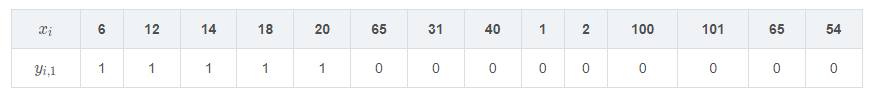
利用 $p_{k, m}(x)=\frac{e^{f_{k, m}(x)}}{\sum_{l=1}^{K} e^{f_{l, m}(x)} \text {, }}$
以 $x_{1}$ 举例， $p_{1,0}=1 /(1+1+1)=0.3333$ ，对于所有的 $x$ 计算得到下表:

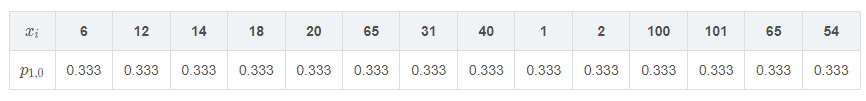
下面计算负梯度值，以 $x_{1}$ 为例 $(k=1, i=1)$ :
$$
\begin{aligned}
&\tilde{y}_{i k}=y_{i, k}-p_{k, m-1} \\
&\Rightarrow \tilde{y}_{11}=y_{1,1}-p_{1,0}=1-0.3333=0.6667
\end{aligned}
$$
同样地，计算其他样本可以有下表：

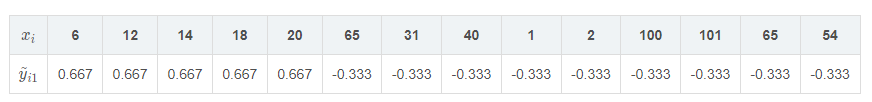
以$\tilde{y}_{i1}$拟合一颗回归树， (以31为分裂点)

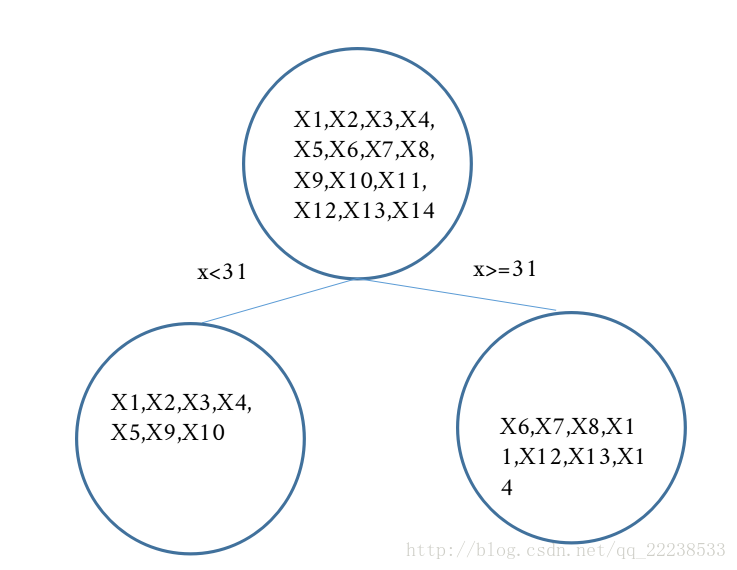

这里简单补充一下，为什么选择 31 作为分裂点。
在GBDT的建树中，可以采用如MSE，MAE等作为分裂准则来确定分裂点 (启发式)。与GBDT做回归和二分类相同，本 例子采用的分裂准则是MSE，具体计算过程如下。
遍历所有特征的取值，将每个特征值依次作为的分裂点，然后计算左子结点与右子结点上的MSE，寻找两老 5 英 $\cdot$, () () 个。
比如，选择1作为分裂点时 $(x<1)$
左子结点上的集合的MSE为: $M S E_{\text {left }}=(-0.3333-(-0.3333))^{2}=0$
右子节点上的集合的MSE为:
$M S E_{\text {right }}=(0.6667-0.02384)^{2}+(0.6667-0.02384)^{2}+\ldots . .+(-0.3333-0.02384)^{2}=3.2142$
故总的MSE为: $M S E=M S E_{\text {left }}+M S E_{\text {right }}=0+3.2142=3.2142$
比如选择2作为分裂点时 $(x<2)$
$M S E_{l e f t}=0, M S E_{\text {right }}=3.07692, M S E=3.07692$
计算完后可以发现，当选择31做为分裂点时，可以得到最小的MSE，MSE $=1.42857$



和前面例子类似，分别计算每个叶节点的值 $c_{j k m}$ 可得:
$$
c_{111}=1.1428 ， c 211=-0.9999 \text { 。 }
$$
$c_{111}$ (第1次迭代时第1个类别的第1个叶节点区域) 求解的详细过程如下:
根据公式
$$
c_{j k m}=\frac{K-1}{K} \frac{\sum_{x_{i} \in R_{j k m}} \tilde{y}_{i k}}{\sum_{x_{i} \in R_{j k m}}\left|\tilde{y}_{i k}\right|\left(1-\left|\tilde{y}_{i k}\right|\right)}
$$
$$
\begin{gathered}
c_{111}=\frac{2}{3} \frac{0.667+0.667+0.667+0.667+0.667-0.333-0.333}{} \\
=\frac{2}{3} \frac{12}{7}=\frac{8}{7}=1.1428
\end{gathered}
$$
在这里 $0.667$ 当作 $\frac{2}{3} ， 0.333$ 当作 $\frac{1}{3}$ ，且相同的数进行了归并。
同理， $c_{211}=-0.999$ 也是这么算的。
最后，更新 $f_{k m}\left(x_{i}\right)=f_{k, m-1}\left(x_{i}\right)+\rho * \sum_{x_{i} \in R_{i k m}} c_{j k m} * I\left(x_{i} \in R_{j k m}\right)$ ，可得下表，这里 $\rho=1$

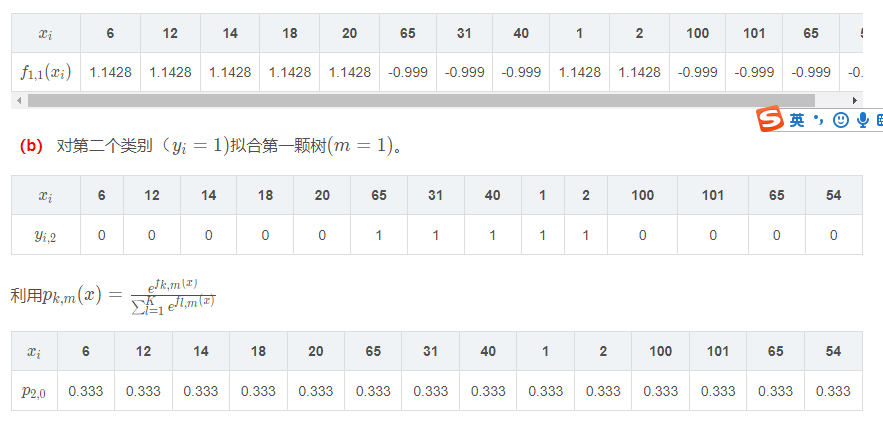

下面计算负梯度值，以 $x_{1}$ 为例 $(k=2, i=1)$ :
$$
\begin{aligned}
&\tilde{y}_{i k}=y_{i, k}-p_{k, m-1} \\
&\Rightarrow \tilde{y}_{12}=y_{1,2}-p_{2,0}=0-0.3333=-0.3333
\end{aligned}
$$
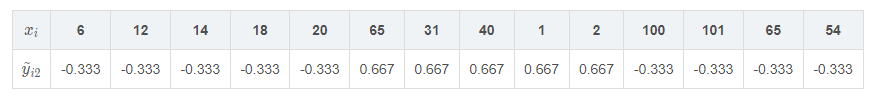

以 $\tilde{y}_{i 2}$ 拟合一颗回归树， (以6为分裂点), 可计算得到叶子节点:
$$
c_{121}=2, c_{221}=-0.2499
$$
更新 $f_{k m}\left(x_{i}\right)=f_{k, m-1}\left(x_{i}\right)+\rho * \sum_{x_{i} \in R_{j k m}} c_{j k m} * I\left(x_{i} \in R_{j k m}\right)$ ，可得下表：
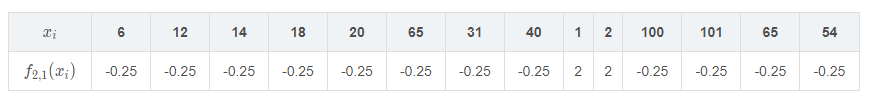

(c) 然后再拟合第三个类别（类别 2 ) 的第一颗树，过程也是重复上述步骙，所以这里就不再重复了。
(3) 步骤三: 在拟合完所有类别的第一颗树后就开始拟合第二颗树。反复进行，直到训练了M轮。
NOTE：经过第一轮训练，我们得到了 $f_{1,1}\left(x_{1}\right) ， f_{2,1}\left(x_{1}\right) ， f_{3,1}\left(x_{1}\right)$ 分别代表了样本 $x_{1}$ 在 3 个类别的得分，现在我们仍 然应该将其转化为概率。
参考二分类的例子，对于采用logloss作为损失函数的情况下， $p_{k i}=\frac{1}{1+e^{\left(-f k m\left(x_{i}\right)\right)}}$, 就可以将得分转化为概率，哪个概率  大就属于哪类。
